# **Image Colorization**

<img src="https://learnopencv.com/wp-content/uploads/2018/07/colorization-example.png" alt="1" border="0">


# **Task Description**

`Image Colorization` is the process of converting a grayscale image (single-channel) into an image with a specific color spectrum. In this homework, your task is to **create and train a convolutional neural network (CNN) model** to colorize grayscale images to the RGB color spectrum. To demonstrate the effectiveness of CNNs, you will also implement a **linear regression model** for the same task and compare their results.

## **Expectations**

- The **performance does not need to be perfect**, but your **metrics should show better results than random color guessing**, and the **loss should decrease throughout the epochs**.
- You are **free to design any custom shallow convolutional neural network**, as long as it is specifically tailored for the image colorization task.
- You can choose **any dataset** (e.g., `CIFAR-10`, `Caltech101`, `Food101`, `FlickR`) or create a custom dataset by **scraping the web** for a specific theme. If you decide to use web scraping, you can utilize the `icrawler` Python package. Ensure that **no NSFW images** are included.
- If you decide to use a **high-resolution dataset**, apply **resizizing transformations** since the fully connected network’s complexity increases with input size. For example:
  - A $[1\times32\times32]$ grayscale image will have $1,024$ features.
  - A $[1\times512\times512]$ grayscale image will have $262,144$ features, which is $256$ **times more**.
  
## **Requirements**

- Data Visualization:
  - Display **samples from the original dataset**.
  - Show the **transformed grayscale images** at the beginning of the notebook.
  - Present **predicted colorized images** alongside ground truth images.

- Performance Monitoring:
  - **Visualize training and validation losses** after training the network.
  - **Use plots and metrics (e.g., matplotlib, seaborn)** to display performance trends.

- Implement **overfitting prevention techniques**, such as:
  - **Early stopping**
  - **Regularization techniques**
  - **Experimenting with different loss functions**
  - Save the **best-performing model** during training.

- Compare model performance:
  - **Visualize predictions** on a batch of test images.
  - Calculate and display **batch losses for both FCN and CNN models**.
  - Explain why the models perform as they do, **highlighting the strengths and weaknesses** of each approach.


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


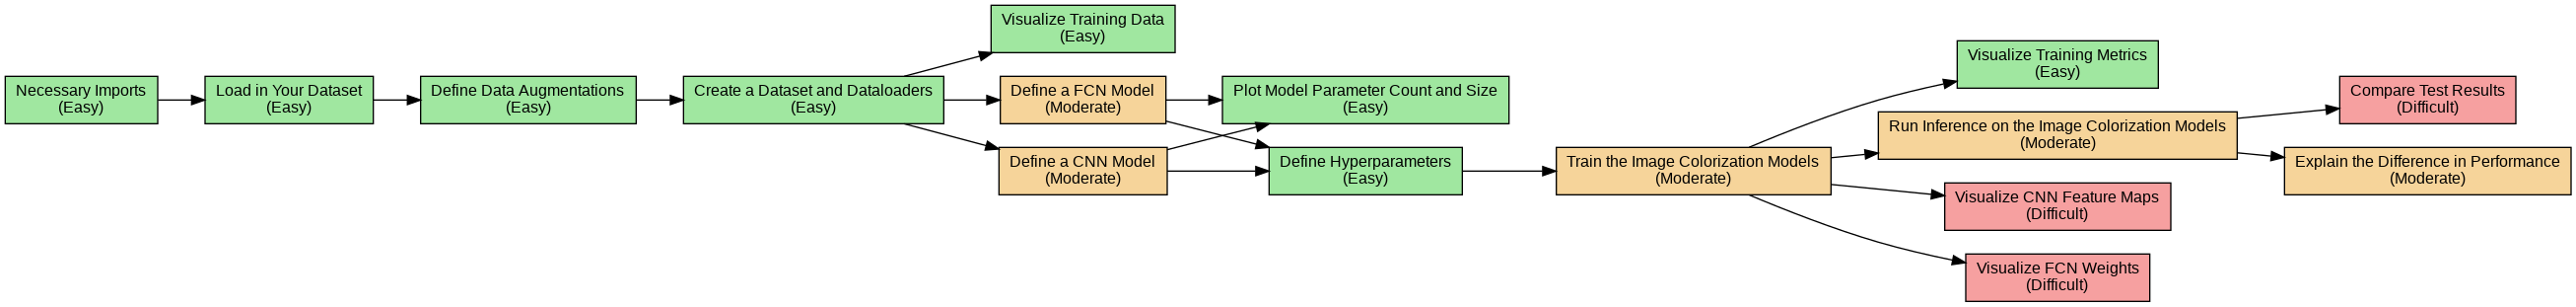

In [2]:
# @title Image Colorization Tasks
# %%capture flowchart_output
# HIDDEN CELL
from graphviz import Digraph
from IPython.display import Image as IMG

def create_flowchart(output_filename='flowchart'):
    dot = Digraph(name='Simplified Object Detection', format='png')
    dot.attr(rankdir='LR')
    dot.attr('node', shape='box', style='filled', fontsize='12', fontname='Arial')

    dot.node('Imports', 'Necessary Imports\n(Easy)', fillcolor='#A0E7A0')
    dot.node('LoadData', 'Load in Your Dataset\n(Easy)', fillcolor='#A0E7A0')
    dot.node('AugmentData', 'Define Data Augmentations\n(Easy)', fillcolor='#A0E7A0')
    dot.node('DatasetDataloader', 'Create a Dataset and Dataloaders\n(Easy)', fillcolor='#A0E7A0')
    dot.node('VisualizeSample', 'Visualize Training Data\n(Easy)', fillcolor='#A0E7A0')
    dot.node('CreateCNN', 'Define a CNN Model\n(Moderate)', fillcolor='#F6D49A')
    dot.node('CreateFCN', 'Define a FCN Model\n(Moderate)', fillcolor='#F6D49A')

    dot.node('TorchSummary', 'Plot Model Parameter Count and Size\n(Easy)', fillcolor='#A0E7A0')
    dot.node('Hyperparameters', 'Define Hyperparameters\n(Easy)', fillcolor='#A0E7A0')

    dot.node('TrainModel', 'Train the Image Colorization Models\n(Moderate)', fillcolor='#F6D49A')

    dot.node('VisualizeTrain', 'Visualize Training Metrics\n(Easy)', fillcolor='#A0E7A0')

    dot.node('RunInference', 'Run Inference on the Image Colorization Models\n(Moderate)', fillcolor='#F6D49A')

    dot.node('CompareResults', 'Compare Test Results\n(Difficult)', fillcolor='#F6A0A0')
    dot.node('ExplainResults', 'Explain the Difference in Performance\n(Moderate)', fillcolor='#F6D49A')

    dot.node('VisualizeFM', 'Visualize CNN Feature Maps\n(Difficult)', fillcolor='#F6A0A0')
    dot.node('VisualizeW', 'Visualize FCN Weights\n(Difficult)', fillcolor='#F6A0A0')

    # Edges
    dot.edge('Imports', 'LoadData')
    dot.edge('LoadData', 'AugmentData')

    dot.edge('AugmentData', 'DatasetDataloader')
    dot.edge('DatasetDataloader', 'CreateCNN')
    dot.edge('DatasetDataloader', 'VisualizeSample')
    dot.edge('DatasetDataloader', 'CreateFCN')

    dot.edge('CreateCNN', 'TorchSummary')
    dot.edge('CreateFCN', 'TorchSummary')
    dot.edge('CreateCNN', 'Hyperparameters')

    dot.edge('CreateFCN', 'Hyperparameters')
    dot.edge('Hyperparameters', 'TrainModel')

    dot.edge('TrainModel', 'VisualizeTrain')
    dot.edge('TrainModel', 'RunInference')
    dot.edge('TrainModel', 'VisualizeFM')
    dot.edge('TrainModel', 'VisualizeW')
    dot.edge('RunInference', 'CompareResults')
    dot.edge('RunInference', 'ExplainResults')

    dot.render(output_filename, view=False)

create_flowchart('homework1_flowchart')
IMG('homework1_flowchart.png')

Each section of the Notebook will guide you through the task:
- `necessary imports`
- `data loading process`
- `defining data augmentations`
- `creating a dataset and dataloaders`
- `visualizing the training data`
- `creating a CNN model`
- `creating a FCN model`
- `defining a loss function and an optimizer`
- `creating a training and validation loop`
- `testing the models`
- `comparing results`

## **0. Necessary Imports**
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

## **1. Data Loading Process**

If you're unsure which dataset to use, **PyTorch** provides a collection of **pre-built datasets** in its [documentation](https://pytorch.org/vision/main/datasets.html). Look for a dataset under the *Image Classification* section that contains colored images.

**Caltech-101:**

<img src=" https://datasets.activeloop.ai/wp-content/uploads/2022/09/Caltech-101-dataset-main-image.webp" alt="1" border="0">

**CIFAR-10:**

<img src=" https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-10-dataset-Activeloop-Platform-visualization-image-1.webp" alt="1" border="0">

**Food-101:**

<img src=" https://storage.googleapis.com/kaggle-datasets-images/2918922/5029790/277a9147ec4854e4762767c8bd107bec/dataset-card.png?t=2023-02-20-08-37-14" alt="1" border="0">




## **2. Defining Augmentations**

Since most datasets and images are in RGB color space, you'll need to convert them to grayscale. However, we **strongly recommend** against applying the grayscale transformation immediately after loading the dataset, as this would result in losing the original colored images (which serve as the target). Instead, apply essential preprocessing steps like `tensor conversion`, `normalization` and `resizing` first, and **only perform the grayscale transformation within the custom Dataset class** to retain access to both input (grayscale) and target (RGB) images.

```python
train_transforms = transforms.Compose([
            # Add Augmentations
])

test_transforms = transforms.Compose([
            # Add Augmentations
])
```

In [42]:
H, W = 128, 128
train_transforms = transforms.Compose([
    transforms.Resize((H, W)),                # Resize images
    transforms.RandomHorizontalFlip(),          # Augment with random horizontal flip
    transforms.RandomVerticalFlip(),            # Augment with random vertical flip
    transforms.RandomRotation(5),              # Random rotation
    # transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),  # Affine transformations
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transforms = transforms.Compose([
    transforms.Resize((H, W)),                # Resize images
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

## **3. Creating Datasets and Dataloaders**

To train a custom object detection model, a dataset is required. For this assignment, you will create a **custom dataset class** that takes a dataset path as input and returns **input-output** image pairs when batched through a `Dataloader`:

- **Input:** $[1\times H \times W]$ grayscale image  
- **Output:** $[3\times H \times W]$ RGB image  

Use the built-in **`transforms.Grayscale`** method from `torchvision.transforms` to convert images to grayscale.

> **Note:** The $W$ and $H$ dimensions do not necessarily have to be the same.

For the **DataLoader**, ensure that the **batch size** is appropriate so that it fits into memory. Set the **`shuffle`** parameter as follows:

- **Training & Validation DataLoaders:** `shuffle=True` (to randomize the order of samples)  
- **Test DataLoader:** `shuffle=False` (to maintain consistency in evaluation)

```python
class GrayscaleToColorDataset(Dataset):
    def __init__(self):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError

    def __getitem__(self, idx):
        raise NotImplementedError
```

In [43]:
import random

class GrayscaleToColorDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Args:
            dataset (torchvision.datasets): The dataset containing RGB images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the RGB image from the dataset
        rgb_image, _ = self.dataset[idx]

        # Apply transformations (if any)
        if self.transform:
            rgb_image = self.transform(rgb_image)

        grayscale_image = transforms.Grayscale(num_output_channels=1)(rgb_image)

        # The input is grayscale, and the target is RGB
        return grayscale_image, rgb_image


# Downloading the dataset
train_dataset = datasets.Food101(root='./root', split='train', download=True, transform=None)
test_and_valid_dataset = datasets.Food101(root='./root', split='test', download=True, transform=None)

valid_size = int(0.4 * len(test_and_valid_dataset))
test_size = len(test_and_valid_dataset) - valid_size  # Ensure total remains the same

# Splitting into test and valid dataset
valid_dataset, test_dataset = random_split(test_and_valid_dataset, [valid_size, test_size])

# Function to retain a percentage of the dataset using list(range()) and random.shuffle
def retain_percentage(dataset, percentage):
    # Generate a list of indices from 0 to len(dataset) - 1
    indices = list(range(len(dataset)))
    # Shuffle the indices randomly
    random.shuffle(indices)
    # Calculate the number of samples to retain
    retain_size = int(percentage * len(dataset) / 100)
    # Select the first `retain_size` indices
    selected_indices = indices[:retain_size]
    # Create and return a subset of the dataset with the selected indices
    return Subset(dataset, selected_indices)

# Retain only % of train, validation, and test datasets
percentage = 7
train_dataset = retain_percentage(train_dataset, percentage)
valid_dataset = retain_percentage(valid_dataset, percentage)
test_dataset = retain_percentage(test_dataset, percentage)
# Use custom dataset for training
train_custom_dataset = GrayscaleToColorDataset(train_dataset, transform=train_transforms)
valid_custom_dataset = GrayscaleToColorDataset(valid_dataset, transform=test_transforms)
test_custom_dataset = GrayscaleToColorDataset(test_dataset, transform=test_transforms)

# Create DataLoader for batching
train_loader = DataLoader(train_custom_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_custom_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_custom_dataset, batch_size=32, shuffle=False)

# Check dataset sizes
print(f"Training dataset size: {len(train_custom_dataset)}")
print(f"Validating dataset size: {len(valid_custom_dataset)}")
print(f"Testing dataset size: {len(test_custom_dataset)}")

print(train_custom_dataset[0][0])
print(test_custom_dataset[0][0].shape)

Training dataset size: 5302
Validating dataset size: 707
Testing dataset size: 1060
tensor([[[-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
         [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
         [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
         ...,
         [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
         [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
         [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337]]])
torch.Size([1, 128, 128])


## **4.1 Visualize Training Data**

To visualize the training data, extract a batch from the training `DataLoader` and plot the **input-output** pairs using `Matplotlib` or `Seaborn`. Ensure that at least **8 pairs** are displayed for a clear representation.

```python
def visualize_batch():
  raise NotImplementedError
```

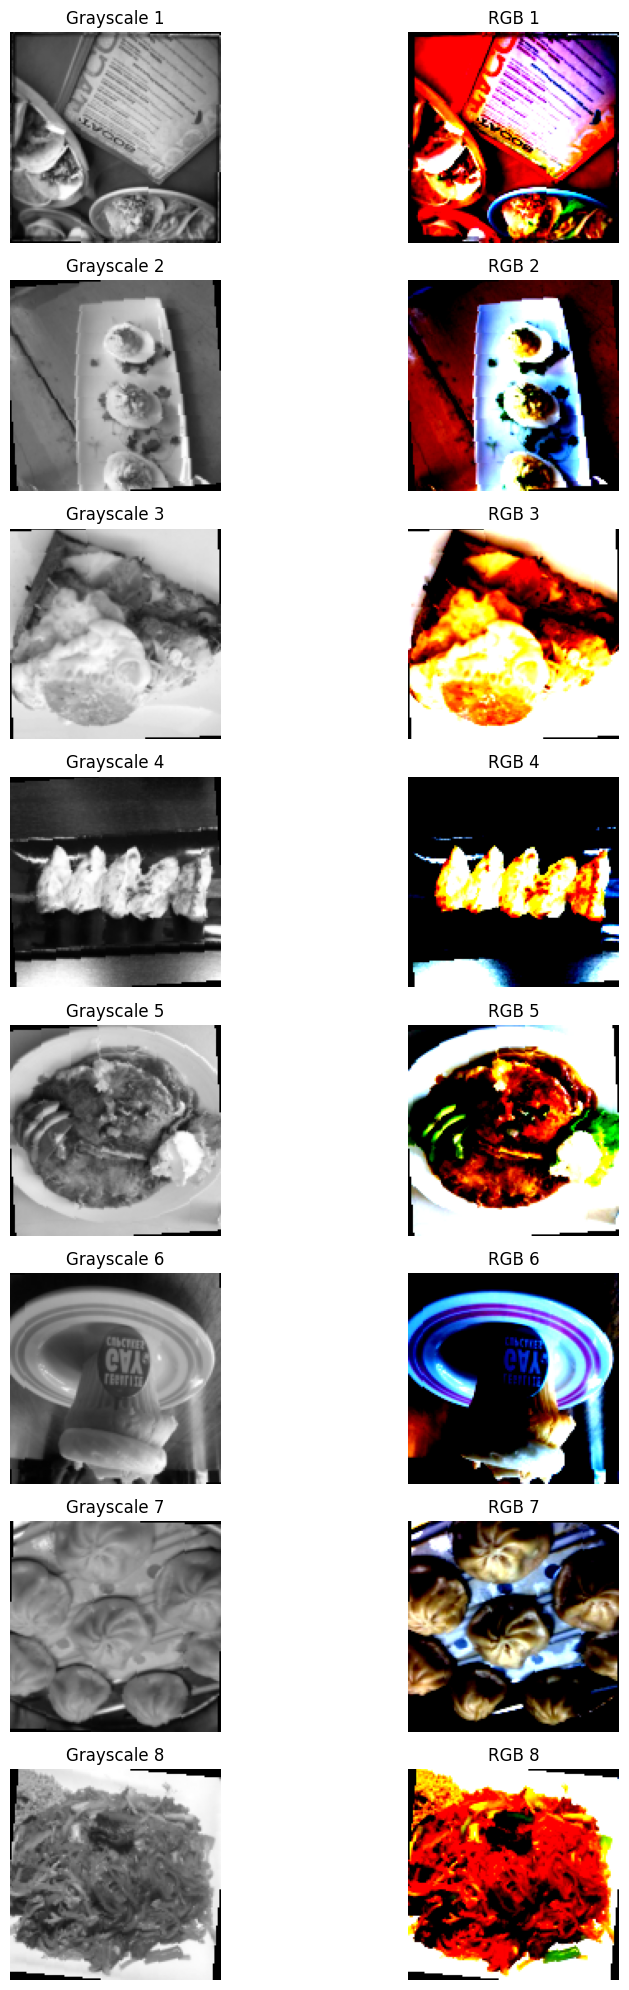

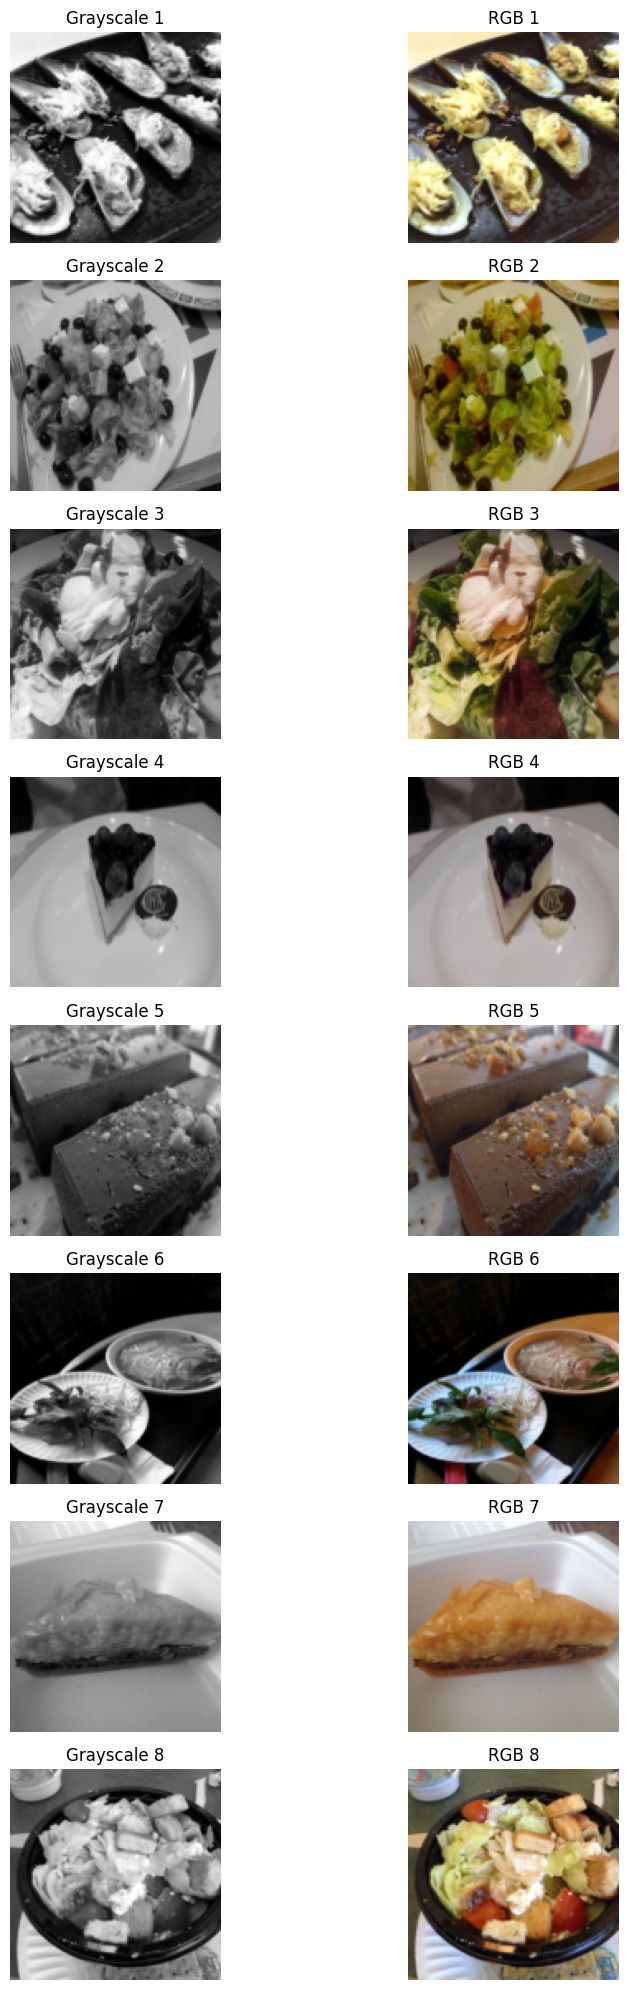

In [44]:
# Define the mean and std used during normalization
mean = np.array([0.485, 0.456, 0.406])  # RGB means
std = np.array([0.229, 0.224, 0.225])   # RGB standard deviations

def denormalize(tensor):
    """
    De-normalizes a tensor image using the original mean and std.
    """
    tensor = tensor.clone()  # Clone to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization: x = x * std + mean
    return tensor

def visualize_batch(batch, num_samples=8, denorm=False):
    """
    Visualizes a batch of input-output pairs from the DataLoader.

    Args:
    - batch (tuple): A batch of (grayscale, RGB) images.
    - num_samples (int): Number of pairs to display.
    """
    grayscale_images, rgb_images = batch

    # Convert tensor images to numpy arrays after de-normalizing RGB
    grayscale_images = grayscale_images.numpy()
    if denorm:
      rgb_images = torch.stack([denormalize(img) for img in rgb_images])  # De-normalize
    rgb_images = rgb_images.numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 20))

    for i in range(num_samples):
        # Grayscale image (input)
        axes[i, 0].imshow(np.squeeze(grayscale_images[i]), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Grayscale {i + 1}")

        # RGB image (output) - De-normalized
        axes[i, 1].imshow(np.transpose(rgb_images[i], (1, 2, 0)).clip(0, 1))  # Clip values for display
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"RGB {i + 1}")

    plt.tight_layout()
    plt.show()

# Extract a batch from the training DataLoader
train_batch = next(iter(train_loader))

# Visualize the batch
visualize_batch(train_batch, num_samples=8, denorm=False)

# Extract another batch from the test DataLoader
test_batch = next(iter(test_loader))

# Visualize the second batch
visualize_batch(test_batch, num_samples=8, denorm=True)


## **4.2 Creating a CNN Model**

You are free to design your CNN using any combination of:
- `Conv2d` layers
- `MaxPool2d`
- Normalization techniques (e.g., `BatchNorm`, `Dropout`)
- Activation functions (e.g., `ReLU`, `LeakyReLU`, etc.)

The final convolutional layer should output a tensor of shape $[3 × H × W]$ to match the RGB color space. Apply a `sigmoid` activation at the end to constrain the output values between **0 and 1**, allowing for later **denormalization** to the full RGB scale.

For an **extra grade improvement**, explore more advanced architectures and techniques:

- **Dilation in Conv2D layers:** Expands the receptive field without increasing parameters.  
  [PyTorch Docs on Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)  

- **Transpose Convolutions:** Used for upsampling to restore spatial dimensions in an image.  
  [PyTorch Docs on ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)  

- **Encoder-Decoder Models & UNets:** Popular in segmentation and image-to-image translation tasks.  
  [Understanding UNet](https://towardsdatascience.com/understanding-u-net-61276b10f360/)  

- **Generative Adversarial Networks (GANs):** Used for high-quality image generation and colorization.  
  [Introduction to GANs](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)  

```python
class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        raise NotImplementedError

    def forward(self, x):
        raise NotImplementedError
```

In [45]:
import torch
import torch.nn as nn

class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output in range [-1,1]
        )

    def forward(self, x):
        # Check if the input is 3D (i.e., a single grayscale image)
        if x.dim() == 3:  # If the input is 3D (shape [1, H, W]), add a batch dimension
            x = x.unsqueeze(0)  # Shape becomes [1, 1, H, W]

        # Pass through the encoder
        x = self.encoder(x)

        # Pass through the decoder
        x = self.decoder(x)

        return x

# Instantiate the model
model_cnn = ColorizationCNN()

# Print the model architecture
print(model_cnn)


# Test the output shape with a sample image from the dataset
print(train_custom_dataset[0][0].shape)
print(model_cnn(next(iter(valid_loader))[0]).shape)

ColorizationCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='bilinear')
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='bilinear')
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Upsample(sc

## **4.3 Creating a FCN Model**

The fully connected network should process an **input grayscale image** and transform it into an RGB image by following these steps:

1. **Flatten the input:**  
   - Convert the image into a vector of shape $[N, 1 * H * W]$, where $N$ is the batch size.
   
2. **Linear Projection:**  
   - Apply a **fully connected (linear) layer** that projects the input vector to a space of $[N, 3 * H * W]$.

3. **Reshape the output:**  
   - Reshape the result back into an image format with shape $[N, 3, H, W]$, matching the expected RGB output.

Feel free to add **more hidden layers** and incorporate **non-linear activation functions**, normalization techniques, and other enhancements to help the model learn more expressive and complex features.

```python
class ColorizationLinear(nn.Module):
    def __init__(self):
        super(ColorizationLinear, self).__init__()
        raise NotImplementedError

    def forward(self, x):
        raise NotImplementedError
```

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ColorizationLinear(nn.Module):
    def __init__(self, H, W):
        super(ColorizationLinear, self).__init__()

        self.H, self.W = H, W  # Store the image dimensions (height, width)
        self.input_size = H * W  # Flattened size of grayscale input
        self.output_size = 3 * H * W  # Flattened size of RGB output

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.input_size, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)              # Second fully connected layer
        self.fc3 = nn.Linear(512, self.output_size)  # Output layer to RGB

    def forward(self, x):
        # Check and add batch dimension if input is 3D (grayscale image)
        if x.dim() == 3:  # If input shape is (1, H, W)
            x = x.unsqueeze(0)  # Shape becomes [1, 1, H, W]

        N, C, H, W = x.shape  # Extract batch size and spatial dimensions
        assert H == self.H and W == self.W, f"Input dimensions must match model dimensions (Expected: {self.H}, {self.W})"

        # Flatten the input image to [N, H * W]
        x = x.view(N, -1)

        # Apply fully connected layers with activation
        x = F.relu(self.fc1(x))  # First hidden layer with ReLU activation
        x = F.relu(self.fc2(x))  # Second hidden layer with ReLU activation
        x = torch.tanh(self.fc3(x))  # Final output layer with Sigmoid to output RGB in [0, 1]

        # Reshape the output to RGB format [N, 3, H, W]
        x = x.view(N, 3, H, W)
        return x




# Example usage
model_fcn = ColorizationLinear(H, W)
print(model_fcn)

# Create a dummy grayscale image
input_image = torch.randn(1, 1, H, W)

# Forward pass
output_image = model_fcn(input_image)

# Output shape should be (N, 3, H, W)
print("Output shape:", output_image.shape)

# Forward pass
output_image2 = model_fcn(train_custom_dataset[0][0])

# Output shape should be (N, 3, H, W)
print("Output shape:", output_image2.shape)

# model_fcn(next(iter(valid_loader))[0]).shape


ColorizationLinear(
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=49152, bias=True)
)
Output shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


## **5.1 Plotting Model Parameter Count and Size**

A convenient way to inspect the number of parameters in a defined `nn.Module` is by using the `torchsummary` package. This package provides a detailed summary of the model architecture, including the number of parameters in each layer, their shapes, and the total parameter count.

To use `torchsummary`, you need to pass a dummy tensor with the specified input shape. The package will then traverse the model, layer by layer, calculating the total number of trainable and non-trainable parameters while also displaying the output shapes at each stage.

Sumnmarize **both models**!

```python
model_cnn = ColorizationCNN().to(device)
summary(model_cnn, input_size = )
```

In [51]:
# Assuming the model is already defined and moved to the device
model_cnn = ColorizationCNN().to(device)


# Adjust this based on your input size
summary(model_cnn, input_size=(1, H, W))  # (1, H, W) is for grayscale input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
              ReLU-2         [-1, 64, 128, 128]               0
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
              ReLU-5          [-1, 128, 64, 64]               0
         MaxPool2d-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 32, 32]         295,168
              ReLU-8          [-1, 256, 32, 32]               0
         MaxPool2d-9          [-1, 256, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         295,040
             ReLU-11          [-1, 128, 16, 16]               0
         Upsample-12          [-1, 128, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          73,792
             ReLU-14           [-1, 64,

In [52]:
# Assuming the model is already defined and moved to the device
model_fcn = ColorizationLinear(H, W).to(device)

# Set the input size for a grayscale image of size HxW
summary(model_fcn, input_size=(1, H, W))  # (1, H, W) is for grayscale input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]      16,778,240
            Linear-2                  [-1, 512]         524,800
            Linear-3                [-1, 49152]      25,214,976
Total params: 42,518,016
Trainable params: 42,518,016
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 0.39
Params size (MB): 162.19
Estimated Total Size (MB): 162.64
----------------------------------------------------------------


## **5.2 Defining Loss Function and Optimizer**

**Loss Functions and their options:**

For our grayscale-to-color image translation task, we are performing **regression** rather than classification. Our network predicts continuous RGB values for each pixel, meaning that the chosen loss function should effectively measure the difference between the predicted and true color values.

---

### **a. Mean Squared Error (MSE) Loss**
MSE loss is a standard choice for regression tasks as it penalizes larger errors more strongly than smaller ones. It is computed as:

$$
\mathcal{L}_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

where $ y_i $ is the ground truth pixel value and $ \hat{y}_i $ is the predicted pixel value.

- **Pros:** Simple, commonly used for regression, computationally efficient.
- **Cons:** Sensitive to outliers since it squares errors.

---

### **b. Root Mean Squared Error (RMSE) Loss**
RMSE is simply the square root of MSE, reducing the impact of squared errors and providing a more interpretable loss value in the same unit as the output.

$$
\mathcal{L}_{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

- **Pros:** Less sensitive to large errors compared to MSE, more interpretable.
- **Cons:** Still punishes large errors significantly.

---

### **c. Huber Loss**
Huber Loss is a combination of MSE and Mean Absolute Error (MAE) that is more robust to outliers. It applies MSE for small errors and MAE for large ones:

$$
\mathcal{L}_{Huber} =
\begin{cases}
\frac{1}{2} (y_i - \hat{y}_i)^2, & \text{if} \ |y_i - \hat{y}_i| \leq \delta \\
\delta (|y_i - \hat{y}_i| - \frac{1}{2} \delta), & \text{otherwise}
\end{cases}
$$

where $ \delta $ is a threshold defining the transition from quadratic to linear loss.

- **Pros:** Robust to outliers while still penalizing significant errors.
- **Cons:** Introduces an extra hyperparameter $ \delta $ that must be tuned.

---

### **d. Structural Similarity Index (SSIM) Loss (Advanced)**
While MSE and Huber loss work on a per-pixel basis, SSIM measures **perceptual similarity** between two images. It compares contrast, structure, and luminance.

$$
\mathcal{L}_{SSIM} = 1 - SSIM(y, \hat{y})
$$

where SSIM measures image similarity in a windowed manner.

- **Pros:** Better reflects human perception of image quality.
- **Cons:** More computationally expensive.

---

[PyTorch Documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)

---

**Optimizers and their options:**

There are some pre-built [Optimizers in PyTorch](https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are Adam (AdamW) and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html))
* **ADA**ptive **M**oment optimizer ([ADAM](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html))
* [A good general overview](https://www.ruder.io/optimizing-gradient-descent/)

In [53]:
# Choose a loss function
criterion = nn.L1Loss()  # You can change this to HuberLoss() or SSIM loss if needed

# Choose an optimizer
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001, weight_decay=1e-5)  # Adam optimizer with L2 regularization

## **6. Training the Image Colorization Models**

When implementing the training loop, ensure the following key aspects are included:

- Set an **appropriate number of epochs** for model training, balancing between underfitting and overfitting.
- Maintain running losses throughout each epoch and compute both **training loss** and **validation loss** per epoch.
- Implement an **early stopping mechanism** to halt training if validation loss stops improving, preventing unnecessary overfitting.
- **Save the model at its best-performing epoch** based on validation loss, ensuring the best version is retained for inference.

In [54]:

# Define training parameters
epochs = 10
patience = 2  # Early stopping patience
best_val_loss_cnn = float('inf')  # Start with an infinite loss for model_cnn
best_val_loss_fcn = float('inf')  # Start with an infinite loss for model_fcn
early_stop_counter_cnn = 0  # Counter for early stopping for model_cnn
early_stop_counter_fcn = 0  # Counter for early stopping for model_fcn
model_cnn_save_path = 'best_model_cnn.pth'  # File path for saving the model
model_fcn_save_path = 'best_model_fcn.pth'  # File path for saving the model

# Assuming model_cnn, model_fcn, criterion, optimizer, train_loader, and test_loader are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_cnn.to(device)
model_fcn.to(device)

# Define variables to track loss for both models
train_losses_cnn = []
val_losses_cnn = []
train_losses_fcn = []
val_losses_fcn = []

# Training loop for model_cnn
print("Training Model CNN...")
for epoch in range(epochs):
    model_cnn.train()  # Set model_cnn to training mode
    running_train_loss_cnn = 0.0
    num_batches = len(train_loader)  # Get the total number of batches for this epoch

    for batch_idx, (grayscale_image, target_image) in enumerate(train_loader):
        grayscale_image = grayscale_image.to(device)
        target_image = target_image.to(device)

        optimizer.zero_grad()  # Zero the gradients for model_cnn

        # Forward pass for model_cnn
        output_image_cnn = model_cnn(grayscale_image)

        # Compute loss for model_cnn
        loss_cnn = criterion(output_image_cnn, target_image)

        # Backward pass and optimization
        loss_cnn.backward()
        optimizer.step()

        running_train_loss_cnn += loss_cnn.item()  # Accumulate the loss for reporting

        # Print loss for every 10th batch (or any other interval)
        if (batch_idx + 1) % 10 == 0:  # Every 10th batch
            avg_batch_loss_cnn = running_train_loss_cnn / (batch_idx + 1)  # Average loss up to this batch
            print(f"Epoch [{epoch+1}/{epochs}] - Batch [{batch_idx+1}/{num_batches}] - "
                  f"Train Loss (CNN): {avg_batch_loss_cnn:.4f}")

    # Compute and print the average training loss for the entire epoch
    avg_train_loss_cnn = running_train_loss_cnn / len(train_loader)
    train_losses_cnn.append(avg_train_loss_cnn)  # Store the training loss for model_cnn

    # Compute validation loss for model_cnn after each epoch
    model_cnn.eval()  # Set model_cnn to evaluation mode
    with torch.no_grad():  # No need to track gradients for validation
        val_loss_cnn = 0.0
        for val_grayscale_image, val_target_image in valid_loader:
            val_grayscale_image = val_grayscale_image.to(device)
            val_target_image = val_target_image.to(device)

            # Forward pass for model_cnn
            val_output_image_cnn = model_cnn(val_grayscale_image)

            # Compute validation loss for model_cnn
            val_loss_cnn += criterion(val_output_image_cnn, val_target_image).item()

        avg_val_loss_cnn = val_loss_cnn / len(test_loader)
    val_losses_cnn.append(avg_val_loss_cnn)  # Store the validation loss for model_cnn

    # Early stopping check and saving model_cnn
    if avg_val_loss_cnn < best_val_loss_cnn:
        best_val_loss_cnn = avg_val_loss_cnn
        early_stop_counter_cnn = 0
        torch.save(model_cnn.state_dict(), model_cnn_save_path)
    else:
        early_stop_counter_cnn += 1

    if early_stop_counter_cnn >= patience:
        print("Early stopping triggered for model_cnn. Training will stop.")
        break

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss (CNN): {avg_train_loss_cnn:.4f}, "
          f"Validation Loss (CNN): {avg_val_loss_cnn:.4f}")


# Training loop for model_fcn
print("Training Model FCN...")
for epoch in range(epochs):
    model_fcn.train()  # Set model_fcn to training mode
    running_train_loss_fcn = 0.0
    num_batches = len(train_loader)  # Get the total number of batches for this epoch

    for batch_idx, (grayscale_image, target_image) in enumerate(train_loader):
        grayscale_image = grayscale_image.to(device)
        target_image = target_image.to(device)

        optimizer.zero_grad()  # Zero the gradients for model_fcn

        # Forward pass for model_fcn
        output_image_fcn = model_fcn(grayscale_image)

        # Compute loss for model_fcn
        loss_fcn = criterion(output_image_fcn, target_image)

        # Backward pass and optimization
        loss_fcn.backward()
        optimizer.step()

        running_train_loss_fcn += loss_fcn.item()  # Accumulate the loss for reporting

        # Print loss for every 10th batch (or any other interval)
        if (batch_idx + 1) % 10 == 0:  # Every 10th batch
            avg_batch_loss_fcn = running_train_loss_fcn / (batch_idx + 1)  # Average loss up to this batch
            print(f"Epoch [{epoch+1}/{epochs}] - Batch [{batch_idx+1}/{num_batches}] - "
                  f"Train Loss (FCN): {avg_batch_loss_fcn:.4f}")

    # Compute and print the average training loss for the entire epoch
    avg_train_loss_fcn = running_train_loss_fcn / len(train_loader)
    train_losses_fcn.append(avg_train_loss_fcn)  # Store the training loss for model_fcn

    # Compute validation loss for model_fcn after each epoch
    model_fcn.eval()  # Set model_fcn to evaluation mode
    with torch.no_grad():  # No need to track gradients for validation
        val_loss_fcn = 0.0
        for val_grayscale_image, val_target_image in valid_loader:
            val_grayscale_image = val_grayscale_image.to(device)
            val_target_image = val_target_image.to(device)

            # Forward pass for model_fcn
            val_output_image_fcn = model_fcn(val_grayscale_image)

            # Compute validation loss for model_fcn
            val_loss_fcn += criterion(val_output_image_fcn, val_target_image).item()

        avg_val_loss_fcn = val_loss_fcn / len(test_loader)
    val_losses_fcn.append(avg_val_loss_fcn)  # Store the validation loss for model_fcn

    # Early stopping check and saving model_fcn
    if avg_val_loss_fcn < best_val_loss_fcn:
        best_val_loss_fcn = avg_val_loss_fcn
        early_stop_counter_fcn = 0
        torch.save(model_fcn.state_dict(), model_fcn_save_path)
    else:
        early_stop_counter_fcn += 1

    if early_stop_counter_fcn >= patience:
        print("Early stopping triggered for model_fcn. Training will stop.")
        break

    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss (FCN): {avg_train_loss_fcn:.4f}, "
          f"Validation Loss (FCN): {avg_val_loss_fcn:.4f}")


# After training, restore the best model for model_fcn
model_fcn.load_state_dict(torch.load(model_fcn_save_path))
model_fcn.eval()

# Print final losses for model_fcn
print(f"Training Loss (Model FCN): {train_losses_fcn[-1]}")
print(f"Validation Loss (Model FCN): {val_losses_fcn[-1]}")

Training Model CNN...
Epoch [1/10] - Batch [10/166] - Train Loss (CNN): 0.8690
Epoch [1/10] - Batch [20/166] - Train Loss (CNN): 0.8058
Epoch [1/10] - Batch [30/166] - Train Loss (CNN): 0.7632
Epoch [1/10] - Batch [40/166] - Train Loss (CNN): 0.7340
Epoch [1/10] - Batch [50/166] - Train Loss (CNN): 0.7115
Epoch [1/10] - Batch [60/166] - Train Loss (CNN): 0.6970
Epoch [1/10] - Batch [70/166] - Train Loss (CNN): 0.6850
Epoch [1/10] - Batch [80/166] - Train Loss (CNN): 0.6738
Epoch [1/10] - Batch [90/166] - Train Loss (CNN): 0.6658
Epoch [1/10] - Batch [100/166] - Train Loss (CNN): 0.6585
Epoch [1/10] - Batch [110/166] - Train Loss (CNN): 0.6535
Epoch [1/10] - Batch [120/166] - Train Loss (CNN): 0.6479
Epoch [1/10] - Batch [130/166] - Train Loss (CNN): 0.6434
Epoch [1/10] - Batch [140/166] - Train Loss (CNN): 0.6382
Epoch [1/10] - Batch [150/166] - Train Loss (CNN): 0.6337
Epoch [1/10] - Batch [160/166] - Train Loss (CNN): 0.6301
Epoch [1/10] - Train Loss (CNN): 0.6281, Validation Loss (C

## **7.1 Visualizing Training Metrics**

- **Restore the model's parameters** from the checkpoint where validation loss was lowest to use the most optimal version of the model.
- Use `Matplotlib` or `Seaborn` to plot the loss curves over epochs.

Did your model **converge**? Explain your results!

```python
def plot_losses():
  raise NotImplementedError
```

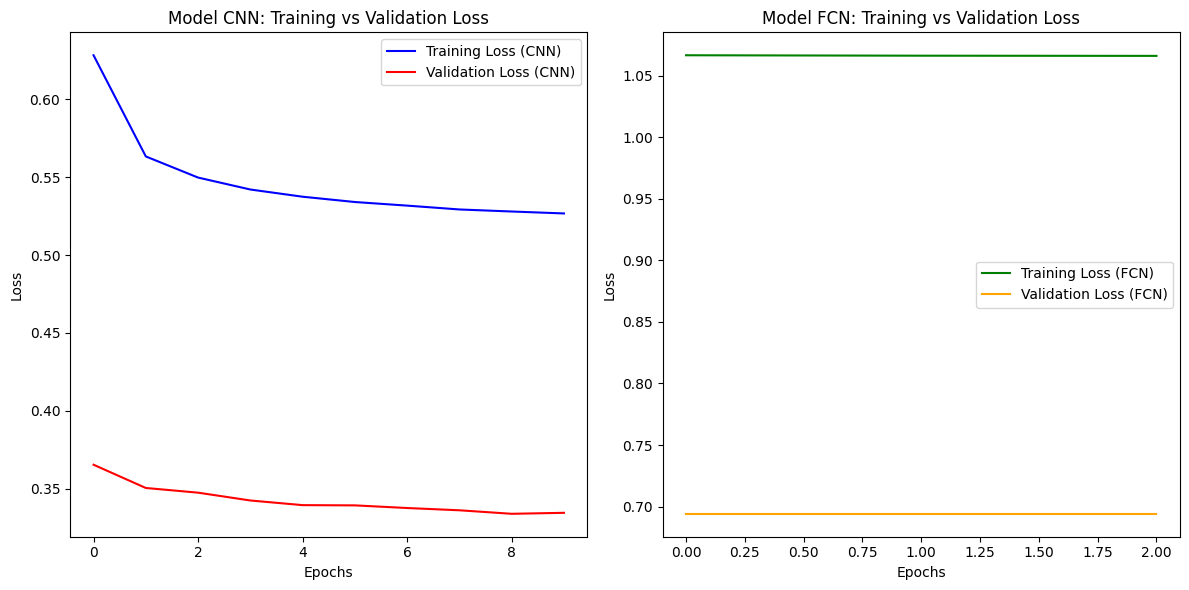

In [55]:
# Restore the best models (already done in the previous training loops)
model_cnn.load_state_dict(torch.load(model_cnn_save_path))
model_cnn.eval()

model_fcn.load_state_dict(torch.load(model_fcn_save_path))
model_fcn.eval()


# Plot training and validation losses for model_cnn
plt.figure(figsize=(12, 6))

# Plotting training and validation loss for Model CNN
plt.subplot(1, 2, 1)
plt.plot(train_losses_cnn, label='Training Loss (CNN)', color='b')
plt.plot(val_losses_cnn, label='Validation Loss (CNN)', color='r')
plt.title("Model CNN: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation loss for Model FCN
plt.subplot(1, 2, 2)
plt.plot(train_losses_fcn, label='Training Loss (FCN)', color='g')
plt.plot(val_losses_fcn, label='Validation Loss (FCN)', color='orange')
plt.title("Model FCN: Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

> **Answer:**

## **7.2 Running Inference on the Image Colorization Models**

Pass test images through both the **CNN-based model** and the **Fully Connected Network (FCN) model**. Compute the test losses for both models to quantify performance.

```python
def test_model()
  raise NotImplementedError
```

In [56]:
# Define the test function
def test_model(model_cnn, model_fcn, test_loader, criterion, device):
    """
    Test both CNN-based model and FCN model on the test set and compute test loss.

    Args:
    - model_cnn (nn.Module): The CNN model to test.
    - model_fcn (nn.Module): The FCN model to test.
    - test_loader (DataLoader): The DataLoader for the test dataset.
    - criterion (nn.Module): The loss function (e.g., MSELoss).
    - device (torch.device): The device to run the model on (GPU or CPU).

    Returns:
    - test_loss_cnn (float): The test loss for the CNN model.
    - test_loss_fcn (float): The test loss for the FCN model.
    """
    # Set both models to evaluation mode
    model_cnn.eval()
    model_fcn.eval()

    # Initialize variables to track test losses for both models
    test_loss_cnn = 0.0
    test_loss_fcn = 0.0
    num_batches = len(test_loader)

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for grayscale_image, target_image in test_loader:
            grayscale_image = grayscale_image.to(device)
            target_image = target_image.to(device)

            # Forward pass through the CNN-based model
            output_image_cnn = model_cnn(grayscale_image)
            loss_cnn = criterion(output_image_cnn, target_image)
            test_loss_cnn += loss_cnn.item()

            # Forward pass through the FCN model
            output_image_fcn = model_fcn(grayscale_image)
            loss_fcn = criterion(output_image_fcn, target_image)
            test_loss_fcn += loss_fcn.item()

    # Compute the average test loss for both models
    test_loss_cnn /= num_batches
    test_loss_fcn /= num_batches

    # Return the test losses for both models
    return test_loss_cnn, test_loss_fcn

# Assuming you have the following:
# - `model_cnn`, `model_fcn`: your trained models
# - `test_loader`: DataLoader for the test dataset
# - `criterion`: the loss function (e.g., nn.MSELoss())
# - `device`: the device (CPU or GPU)

# Call the test function
test_loss_cnn, test_loss_fcn = test_model(model_cnn, model_fcn, test_loader, criterion, device)

# Print test losses for both models
print(f"Test Loss (CNN): {test_loss_cnn:.4f}")
print(f"Test Loss (FCN): {test_loss_fcn:.4f}")


Test Loss (CNN): 0.5052
Test Loss (FCN): 1.0319


## **8.1 Comparing Test Results**

Select **two different test images** and generate comparison plots.
   - For each test image, create a **2-row, 3-column layout**:
     - **Row 1 (CNN Model)**:  
       - **Grayscale Input**
       - **CNN Colorized Prediction**
       - **Ground Truth RGB Image**
     - **Row 2 (FCN Model)**:  
       - **Grayscale Input**
       - **FCN Colorized Prediction**
       - **Ground Truth RGB Image**

> **Display the loss value below each predicted image.**

```python
def plot_predictions():
  raise NotImplementedError
```

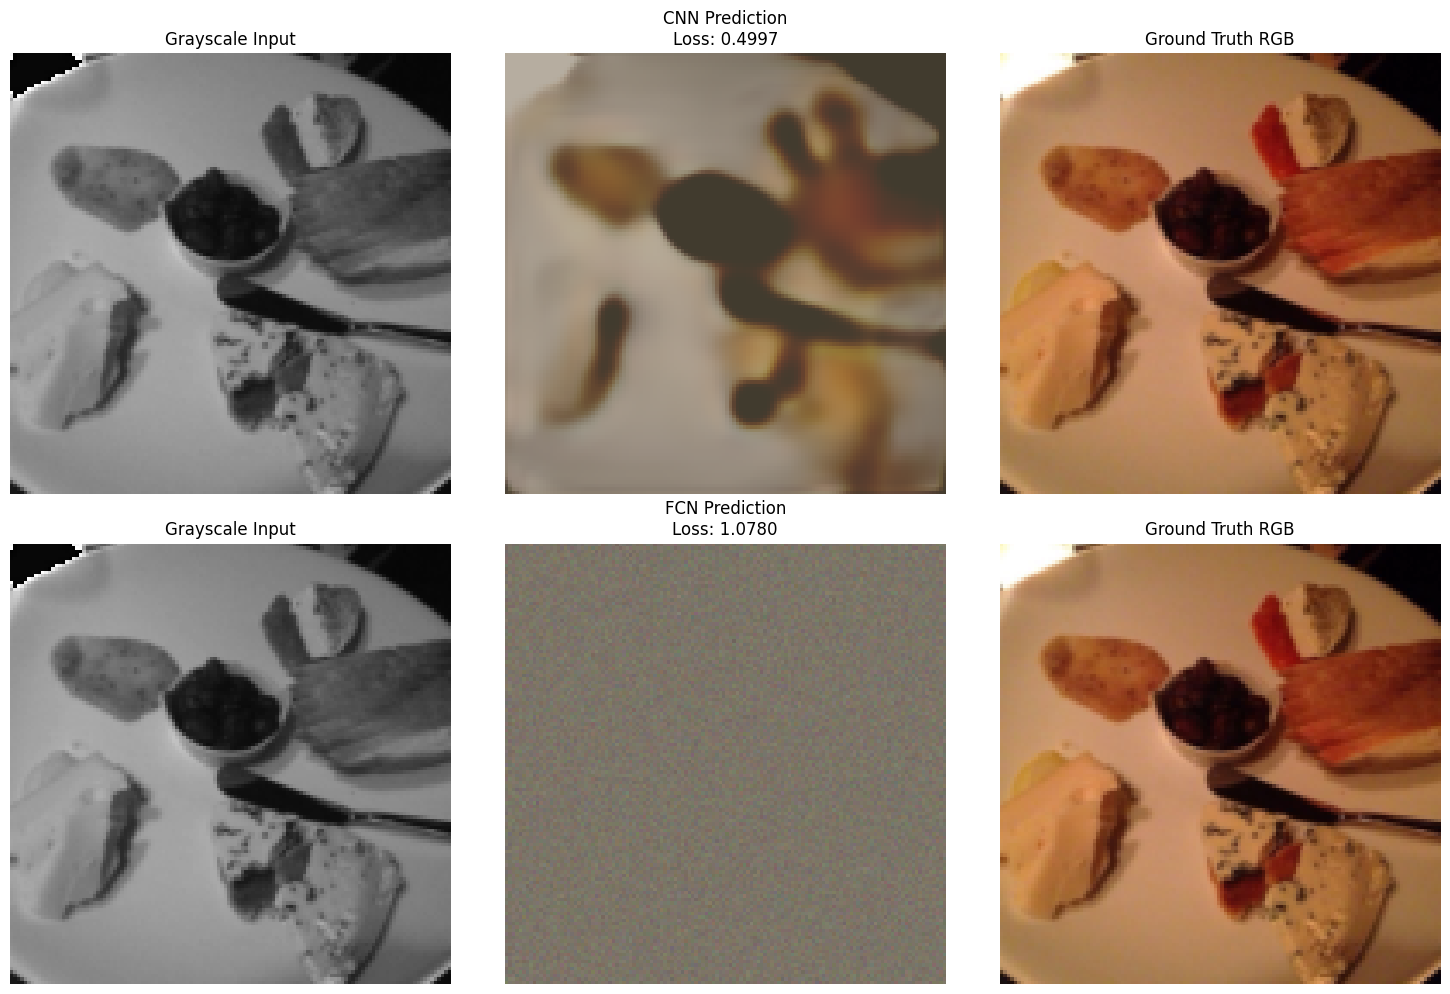

In [75]:
import random

def plot_predictions(test_loader, model_cnn, model_fcn, criterion, device):
    """
    Compares CNN and FCN predictions on test images with proper visualization.
    """
    model_cnn.eval()
    model_fcn.eval()

    to_pil = ToPILImage()

    # Get two test images
    data_iter = iter(test_loader)
    grayscale_image, target_image = next(data_iter)  # Get first batch

    grayscale_image = grayscale_image.to(device)
    target_image = target_image.to(device)

    # Forward pass through both models
    with torch.no_grad():
        output_cnn = model_cnn(grayscale_image)
        output_fcn = model_fcn(grayscale_image)

    # Calculate losses
    loss_cnn = criterion(output_cnn, target_image).item()
    loss_fcn = criterion(output_fcn, target_image).item()

    # Denormalize images before visualization
    random.seed()
    i = random.randint(0, 31)
    grayscale_image = denormalize(grayscale_image[i])  # Single image
    target_image = denormalize(target_image[i])
    output_cnn = denormalize(output_cnn[i])
    output_fcn = denormalize(output_fcn[i])

    # grayscale_image = (grayscale_image[i])  # Single image
    # target_image = (target_image[i])
    # output_cnn = (output_cnn[i])
    # output_fcn = (output_fcn[i])


    # Convert to PIL images for better visualization
    grayscale_pil = to_pil(grayscale_image)
    target_pil = to_pil(target_image)
    output_cnn_pil = to_pil(output_cnn)
    output_fcn_pil = to_pil(output_fcn)

    # Plot results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # CNN results (Row 1)
    axes[0, 0].imshow(grayscale_pil, cmap='gray')
    axes[0, 0].set_title("Grayscale Input")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(output_cnn_pil)
    axes[0, 1].set_title(f"CNN Prediction\nLoss: {loss_cnn:.4f}")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(target_pil)
    axes[0, 2].set_title("Ground Truth RGB")
    axes[0, 2].axis("off")

    # FCN results (Row 2)
    axes[1, 0].imshow(grayscale_pil, cmap='gray')
    axes[1, 0].set_title("Grayscale Input")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(output_fcn_pil)
    axes[1, 1].set_title(f"FCN Prediction\nLoss: {loss_fcn:.4f}")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(target_pil)
    axes[1, 2].set_title("Ground Truth RGB")
    axes[1, 2].axis("off")

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_predictions(test_loader, model_cnn, model_fcn, criterion, device)


## **8.2 Explaining the Difference in Performance**  

Examine the differences in both the predicted test images and the computed test losses, providing reasoning for the performance variations between the two models. Provide explanations on how these architectural differences impact both qualitative (visual) and quantitative (loss-based) performance.


> **Answer:** # Answer:The main problem with FCNs is that when it comes to model image related tasks they don't perform good in comparison with the CNNs The main reason for this is the inability of FCNs to capture the spatial information. The linear, one dimensional, nature of FCNs disable them to capture the relationship between the pixels and their surroundings. CNNS on the otherhand, with the aid of kernels, are able to this quite effectively. For this reason CNNs excel both in terms of qualitaiveness (visually) and quantitativeness (loss wise). 

> Obervation: In terms of Loss FCNs perform worse if the image has less colors (there are patterns). For example for CelebA dataset FCNs do not perform well because face, hair and lips have similar colors in the corresponding areas. As FCNs are not able to capture the spatial information they perform even worse as compared to the images which have diversity in colors. The reason for this can be that the diversity of the colors in the image support the random predictions made by the FCNs. CNNs on the other hand perform even well because they can take advantage of the similar colors around each pixel

In [ ]:
# Answer:The main problem with FCNs is that when it comes to model image related tasks
# they don't perform good in comparison with the CNNs. The main reason for this is the inability 
# of FCNs to capture the spatial information. The linear, one dimensional, nature of FCNs disable 
# them to capture the relationship between the pixels and their surroundings. CNNS on the otherhand, 
# with the aid of kernels, are able to this quite effectively. For this reason CNNs excel both in 
# terms of qualitaiveness (visually) and quantitativeness (loss wise).
# Obervation: In terms of Loss FCNs perform worse if the image has less colors (there are patterns). 
# For example for CelebA dataset FCNs do not perform well because face, hair and lips have similar colors in the corresponding areas. 
# As FCNs are not able to capture the spatial information they perform even worse as compared to the images which have diversity in colors.
# The reason for this can be that the diversity of the colors in the image support the random predictions made by the FCNs. 
# CNNs on the other hand perform even well because they can take advantage of the similar colors around each pixel